In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
! pip install trackpy
import trackpy as tp
! pip install pims
import pims
%matplotlib inline
import scipy
from skimage.io import imread,imshow
from skimage.measure import profile_line as pl
from scipy.ndimage.filters import gaussian_filter  as filt
import datetime
! pip install pyprog
import progressbar
import pyprog
import math
import warnings;warnings.filterwarnings("ignore")
import cv2
import os


def finimage(data,lct,window):
    # return dataframe with points distance betweed window lentgh 
    filt_points=pd.DataFrame()
    for i in range(len(lct)):
        exp=lct.iloc[:,[0,1]].copy()
        exp=abs(exp-exp.iloc[i,])
        final=exp.loc[((exp.iloc[:,1]<window) & (exp.iloc[:,0]<window)),:]
        id=final.index
        a=pd.DataFrame({i:id})
        filt_points=pd.concat([filt_points,a],axis=1,ignore_index=True)
    return filt_points


def pixel(targeted_points,bpass,lct,order):
    # target points --return output of finimage
    # bandpass- numpy  array of bandpass image
    # lct - tp.locate
    # order - manupulate poitns if out of index
    from skimage.measure import profile_line as pl
    dpx=pd.DataFrame()
    for particlei in range(targeted_points.shape[1]):
        b=[]
        for sub_particlei in range(targeted_points.shape[0]):
            sub_x_cord=lct.iloc[targeted_points.columns[particlei],1]
            sub_y_cord=lct.iloc[targeted_points.columns[particlei],0]
            if targeted_points.iloc[sub_particlei,particlei] != "out":
                cordx=lct.iloc[int(targeted_points.iloc[sub_particlei,particlei]),1]
                cordy=lct.iloc[int(targeted_points.iloc[sub_particlei,particlei]),0]
                trial=pl(bpass,(sub_y_cord,sub_x_cord),(cordy,cordx),order=1,mode="nearest")
                b.append(trial)
        new=pd.DataFrame({particlei:b})
        dpx=pd.concat([dpx,new],axis=1,ignore_index=True)
    return dpx

def cord(points_relation,pixelf,threshold):
    finalc=pd.DataFrame()
    for i in range(pixelf.shape[1]):
        a=[]
        for j in range(pixelf.shape[0]):
            if (pixelf.iloc[j,i] is not np.nan) :
                if len(pixelf.iloc[j,i])>1:
                    l=True
                    for k in range(len(pixelf.iloc[j,i])):
                        if pixelf.iloc[j,i][k]<threshold:
                            l=False
                    if l:
                        a.append(points_relation.iloc[j,i])
            else:
                continue
        s=pd.DataFrame({i:a})
        finalc=pd.concat([finalc,s],axis=1,ignore_index=True)
    return finalc

def length(data,point1,point2,max,c,b,threshold,lct):
    max=max
    c=c
    b=b
    from skimage.measure import profile_line as pl
    xi,yi=lct.iloc[point1,0],lct.iloc[point1,1]
    xj,yj=lct.iloc[point2,0],lct.iloc[point2,1]
    l=len(pl(data,[xi,yi],[xj,yj],mode="nearest"))
    #print(pl(data,[xi,yi],[xj,yj],mode="nearest"),"pixels",point1,point2)
    #print("end ----------",[xi,yi],[xj,yj],pl(data,[xi,yi],[xj,yj],mode="nearest"))
    if l>max and min(pl(data,[xi,yi],[xj,yj],mode="nearest"))>=threshold:
        #print("True",point1,point2)
        max=l
        b=point1
        c=point2
        #print("hii",b,c)
        return  max,b,c
    else:
        #print("else hii",point1,point2)
        
        return max,b,c
def three(data,curd,targeted_points,pixelff,threshold,lct):
    from skimage.measure import profile_line as pl
    d=pd.DataFrame()
    cordz=curd
    for i in cordz.columns:
        #print("new particle--------------------------------------------------------------->>>>>>>>>>>>>>>",i)
        max=0
        c=0
        b=0
        for j in range(cordz.shape[0]):
            if cordz[i][j] != "adarsh":
                p1=int(i)
                p2=int(cordz[i][j])
                max,b,c=length(data,p1,p2,max,c,b,threshold,lct)
                #print(b,c,"-------------------------------------------------------- p1 and p2",p1,p2)
                for k  in range(j,cordz.shape[0]):
                    if cordz[i][k] != "adarsh":
                        p3=int(cordz[i][j])
                        p4=int(cordz[i][k])
                        max,b,c=length(data,p3,p4,max,c,b,threshold,lct)
                        #print(b,"b",c,"c",">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-second for","datafame")
        df2=pd.DataFrame({b:c},index=[0])
        d=pd.concat([d,df2],axis=1,ignore_index=False)
        #print("result\n",d)
    return d

def cord_point(points_relation,result,lct,frame):
    from statistics import mean
    dfpoint=pd.DataFrame()
    for i in range(result.shape[1]):
        c=result.columns[i]
        xi=lct.iloc[c,1]
        yi=lct.iloc[c,0]
        a=[xi]
        b=[yi]
        for j in range(result.shape[0]):
            if result.iloc[j,i]!= "srip":
                xj=lct.iloc[int(result.iloc[j,i]),1]
                yj=lct.iloc[int(result.iloc[j,i]),0]
                a.append(xj)
                b.append(yj)
            else:
                continue
        xf=mean(a)
        yf=mean(b)
        slpe=((b[0]-b[1])/(a[0]-a[1]))
        dx1=pd.DataFrame({"x":xf,"y":yf,"tan(Q)":slpe,"frame":frame},index=[0])
        dfpoint=dfpoint.append(dx1,ignore_index=True)
    return dfpoint

def  track(data,output,major=10,minor=4):# output :DataFrame having centroid,slope,frame,i.e. ellipse_cen(data,lct,window=20,threshold=127,frame=1)
    img=data
    warnings.filterwarnings("ignore")
    plt.subplots(1,1,figsize=[30,30]);plt.subplot(1,1,1)
    for i in range(len(output)):
        cx=output.iloc[i,0]
        cy=output.iloc[i,1]
        sl=output.iloc[i,2]
        major=major
        minor=minor
        q=np.linspace(0,2*np.pi,100)
        a=math.atan(sl)
        center_coordinates=(int(cx),int(cy))
        axesLength=(major,minor)
        angle=np.degrees(a)
        #angle=sl
        startAngle=0
        endAngle=360
        color=(0,0,255)
        thickness=1
        image = cv2.ellipse(img, center_coordinates, axesLength, angle,startAngle, endAngle, color, thickness)
    return plt.imshow(image,cmap="gray")

def drawing(data,bandpass,lct,final,a,b):
    warnings.filterwarnings("ignore")
    plt.subplots(1,1,figsize=[30,30]);plt.subplot(1,1,1);plt.imshow(data,cmap="gray")
    #plt.plot(final.iloc[:,0],final.iloc[:,1],"og");
    #plt.plot(lct.iloc[:,1],lct.iloc[:,0],".r")
    x=final.iloc[:,0];y=final.iloc[:,1];angle=final.iloc[:,2];a=a;b=b
    t=np.linspace(0,2*math.pi,200);orient=angle;
    for i in range(len(final)):
        px=x[i];py=y[i];q=math.atan(orient[i])
        cx=px+a*np.cos(t)*np.cos(q)-b*np.sin(t)*np.sin(q);
        cy=py+a*np.cos(t)*np.sin(q)+b*np.sin(t)*np.cos(q);
        plt.plot(cx,cy,".r",linewidth=0.8,antialiased=True) 
    return 

def ellipse_cen(data,lct,window,threshold,frame,bpass):
    bar = progressbar.ProgressBar(maxval=20, \
    widgets=[progressbar.Bar('>', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i=1
    
    # data- image numpy array print
    # lct- tp.locate(data)
    # window- max distance bween 2 points
    # threshold - pixel intensity must be greater than yhresold
    # frame - frame no
    # calculating points beween swindow size distance

    points=finimage(data,lct,window) 
    i+=1;bar.update(i+1)
    # reoplcae nan values  with "out"
    targeted_points=points.replace(np.nan,"out")
    i+=1;bar.update(i+1)
    # return dataframe with calculated relation points
    pixelff=pixel(targeted_points,bpass,lct,1) #@
    i+=1;bar.update(i+1)
    # now keep those points whose pixel values is greater than threshold
    cordz=cord(targeted_points,pixelff,threshold)#@
    i+=1;bar.update(i+1)
    cordc=cordz.dropna(axis=1,how="all")#@
    i+=1;bar.update(i+1)
    cordzz=cordc.replace(np.nan,"adarsh")#@
    i+=1;bar.update(i+1)
    # tackling the 3 centroid points
    #dd=three(data1,cordzz,targeted_points,pixelff,threshold=120,lct=lct1)
    s=three(data,cordzz,targeted_points,pixelff,threshold,lct)
    i+=1;bar.update(i+1)
    # final x and y cordinate of centroids
    final=cord_point(targeted_points,s,lct,frame=frame)
    i+=1;bar.update(i+1)
    cordz;bar.finish()
    return final


     |████████████████████████████████| 131 kB 5.0 MB/s 
  Created wheel for trackpy: filename=trackpy-0.5.0-py3-none-any.whl size=128767 sha256=86b25e19c74a4b4a3a22daebf2aeb914f3f67a0fb4fdc7861189b52da1e988e8
  Stored in directory: /root/.cache/pip/wheels/fa/0b/63/748d0a53a28526c0bfd68b1b71b3a107060a1cfdb5849ae2d1
Successfully built trackpy
     |████████████████████████████████| 85 kB 2.6 MB/s 
  Created wheel for pims: filename=PIMS-0.5-py3-none-any.whl size=84326 sha256=4607f355a6a84e8e29db76011a06ad427a943a20674a53ffa343ee4e78165b91
  Stored in directory: /root/.cache/pip/wheels/75/02/a9/86571c38081ba4c1832eb95430b5d588dfa15a738e2a603737
Successfully built pims
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2277376/45929032 bytes (5.0%)55

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
datastore=pims.ImageSequence(r"/content/drive/MyDrive/srip data/data7/phi_7");
bandpass=pims.ImageSequence(r"/content/drive/MyDrive/srip data/data7/set7_bandpass")
data1=datastore[0];bandpass1=bandpass[0];lct1=tp.locate(data1,7)
%timeit ellipse_cen(data1,lct1,window=25,threshold=180,frame=0,bpass=bandpass[0])

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100%
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100%
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100%
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100%
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100%
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100%


1 loop, best of 5: 1min 55s per loop


In [ ]:
datastore=pims.ImageSequence(r"/content/drive/MyDrive/srip data/data7/phi_7");
bandpass=pims.ImageSequence(r"/content/drive/MyDrive/srip data/data7/set7_bandpass")
os.chdir(r"/content/drive/MyDrive/srip data/data7/phi_7_images_final")
import gc
for ii in range(1):
    data1=datastore[ii];bandpass1=bandpass[ii];lct1=tp.locate(data1,7)
    df=pd.DataFrame()
    r=ellipse_cen(data1,lct1,window=25,threshold=180,frame=ii,bpass=bandpass[ii])
    df=df.append(r,ignore_index=True)
    data1=datastore[ii];bandpass1=bandpass[ii]
    drawing(data1,bandpass1,lct1,r,a=14,b=5)
    plt.xlabel("FIGURE INDEX ----> {j}".format(j=ii),fontsize="12")
    #plt.savefig("{i}-figure".format(i=ii))
    plt.close()
    plt.clf()
    #df.to_csv(r"/content/drive/MyDrive/srip data/data7/phi_7_dataframe/frame_{i}.csv".format(i=ii))
    gc.collect()
    del bandpass1;del df;del data1;del lct1;del r

In [ ]:
data1=datastore[0];bandpass1=bandpass[0];lct1=tp.locate(data1,7)
df=pd.DataFrame()
#%timeit r=ellipse_cen(data1,lct1,window=25,threshold=180,frame=0,bpass=bandpass[0])

NameError: ignored

In [ ]:
main=np.array(data1)

In [ ]:
plt.subplots(1,1,figsize=[30,30]);plt.subplot(1,1,1);plt.imshow(data1,cmap="gray")
plt.plot(lct1.iloc[:,1],lct1.iloc[:,0],".")

In [ ]:
import trackpy as tp
lct1=tp.locate(data1,7)

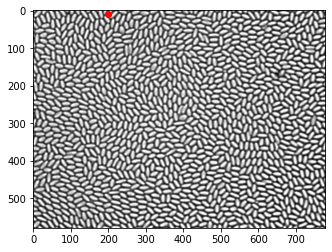

In [ ]:
plt.imshow(data1,cmap="gray")
plt.plot(200,10,"ro")

Start:

In [ ]:
def quick(data,a,b,i):
  if b-a<=1:
    return data
  lower=a+1
  pivot=data[a][i]
  for j in range(a+1,b):
    if data[j][i]< pivot:
      data[j],data[lower]=data[lower],data[j]
      lower+=1
  data[a],data[lower-1]=data[lower-1],data[a]
  lower-=1
  quick(data,a,lower+1,i)
  quick(data,lower+1,b,i)
  return data
swati=None
dist=None
def calc(x,y):
  out=((x[0]-y[0])**(2)+(x[1]-y[1])**2)**(1/2)
  return out

def points(samp):
  global swati
  global dist
  if len(samp)<=1:
    return
  if len(samp)==2:
    distance=calc(samp[0],samp[1])
    #distance=((samp[0][0]-samp[1][0])**2+(samp[0][1]-samp[1][1])**2)**(1/2)
    if not swati:
      swati=samp
      dist=distance
    else:
      if distance<dist:
        dist=distance
        swati=samp
  else:
    mid=len(samp)//2
    left=samp[0:mid+1]
    right=samp[mid:]
    points(left)
    points(right)
    test=[]
    index=mid
    while  samp[mid][0]-samp[index][0]<=dist and index>=0:
      test.insert(0,samp[index])
      index=index-1
    index=mid+1
    while samp[index][0]-samp[mid][0]<=dist and index <len(samp):
      test.append(samp[index])
      index=index+1
      if index>=len(samp):
        break
      #print(index,samp[index])
    new=quick(test,0,len(test),1)
    #print(new)
    min(new)
  return swati
def min(samp):
  global dist
  for i in range(len(samp)):
    p1=samp[i]
    start=1
    while start<=7:
      try:
        p2=samp[i+start]
      except:
        break
      out=calc(p1,p2)
      if out<dist:
        dist=out
        swati=[p1,p2]
      start+=1
  return 

In [ ]:
def quick(data,a,b,i):
  if b-a<=1:
    return data
  lower=a+1
  pivot=data[a][i]
  for j in range(a+1,b):
    if data[j][i]< pivot:
      data[j],data[lower]=data[lower],data[j]
      lower+=1
  data[a],data[lower-1]=data[lower-1],data[a]
  lower-=1
  quick(data,a,lower+1,i)
  quick(data,lower+1,b,i)
  return data
def calc(x,y):
  out=((x[0]-y[0])**(2)+(x[1]-y[1])**2)**(1/2)
  return out

def new_algo(data1, window=7):
  lct1=tp.locate(data1,window)
  main=np.array(data1)
  x=lct1.iloc[:,1]
  y=lct1.iloc[:,0]
  cordinates=[]
  for i in range(len(x)):
    cordinates.append([x[i],y[i]])
  x=cordinates.copy()
  y=cordinates.copy()
  import sys
  sys.setrecursionlimit(15000)
  sorted_x=quick(x,0,len(x),0)
  sorted_y=quick(y,0,len(y),1)
  d=window*5
  final=[]  # [[pivot_point_cordinate_1,   points which are d distance under in y axis],    [pivot_point_cordinate_2,   points which are d distance under in y axis].......]
  for x in sorted_x:
    record=[]
    node=x
    record.append(node)
    position=sorted_y.index(node)
  #print(sorted_y[position:position+10],node)
    while sorted_y[position][1]-node[1]<d:
      if True:
        record.append(sorted_y[position])
        position+=1
        if position>=len(sorted_y):
          break
    position=sorted_y.index(node)
    while node[1]-sorted_y[position][1]<d:
    #if abs(sorted_y[position][0]-node[0])<d:
      if True:
        record.insert(1,sorted_y[position])
        position-=1
        if position<0:
          break
    final.append(record)
  copy1=final.copy()
  copy2=[]
  for i in copy1:
    new=[]
    for j in i:
      if abs(j[0]-i[0][0])<20:
        new.append(j)
    copy2.append(new)
  from skimage.measure import profile_line as prof_line
  final_data_points=[]          #these will contain data ppoints which are d distance under x and y axis and profile line along it will be greater than threshold.
  filter=copy2.copy()
  for array in filter:
    pivot=array[0]
    pivot_x=pivot[0]
    pivot_y=pivot[1]
    target=[]
    for particle in array:
      trial=prof_line(main,(pivot_y,pivot_x),(particle[1],particle[0]),order=1,mode="nearest")
      if np.min(trial)<180:
        continue
      else:
        if particle not in target:
          target.append(particle)
    if len(target)>2:
    #print(target)
      min=0
      p1=None
      p2=None
      for i in target:
        for j in target:
          output=calc(i,j)
        #print(output,i,j)
          if output>min and output!=0:
            min=output
            p1=i
            p2=j
      target=[p1,p2]
    if len(target)<2:
      continue
    final_data_points.append(target)
  return final_data_points
bandpass=pims.ImageSequence(r"/content/drive/MyDrive/srip data/data7/set7_bandpass")
bandpass1=bandpass[0]
%timeit new_algo(bandpass1,7)

1 loop, best of 5: 49.5 s per loop


In [ ]:
final_data_points
plt.subplots(1,1,figsize=[20,20]);plt.subplot(1,1,1);plt.imshow(data1,cmap="gray")
one =final_data_points[788]
for j in final_data_points:
  for k in j:
    plt.plot(k[0],k[1],"r.")

In [ ]:
x=lct1.iloc[:,1]
y=lct1.iloc[:,0]

In [ ]:
cordinates=[]
for i in range(len(x)):
  cordinates.append([x[i],y[i]])

In [ ]:
x=cordinates.copy()
y=cordinates.copy()

In [ ]:
import sys
sys.setrecursionlimit(15000)
sorted_x=quick(x,0,len(x),0)
sorted_y=quick(y,0,len(y),1)

In [ ]:
# method -1---------------------ignore it
d=15
final=[]
for x in sorted_x:
  record=[]
  node=x
  position=sorted_y.index(node)
  #print(sorted_y[position:position+10],node)
  while sorted_y[position][1]-node[1]<d:
    if abs(sorted_y[position][0]-node[0])<d:
      record.append(sorted_y[position])
      position+=1
      if position>=len(sorted_y):
        break
  position=sorted_y.index(node)
  while node[1]-sorted_y[position][1]<d:
    if abs(sorted_y[position][0]-node[0])<d:
      record.insert(0,sorted_y[position])
      position-=1
      if position<0:
        break
  final.append(record)


KeyboardInterrupt: ignored

In [ ]:
def quick(data,a,b,i):
  if b-a<=1:
    return data
  lower=a+1
  pivot=data[a][i]
  for j in range(a+1,b):
    if data[j][i]< pivot:
      data[j],data[lower]=data[lower],data[j]
      lower+=1
  data[a],data[lower-1]=data[lower-1],data[a]
  lower-=1
  quick(data,a,lower+1,i)
  quick(data,lower+1,b,i)
  return data
swati=None
dist=17
def calc(x,y):
  out=((x[0]-y[0])**(2)+(x[1]-y[1])**2)**(1/2)
  return out

def points(samp):
  global swati
  global dist
  if len(samp)<=1:
    return
  if len(samp)==2:
    distance=calc(samp[0],samp[1])
    #distance=((samp[0][0]-samp[1][0])**2+(samp[0][1]-samp[1][1])**2)**(1/2)
    if not swati:
      swati=samp
      dist=distance
    else:
      if distance<dist:
        dist=distance
        swati=samp
  else:
    mid=len(samp)//2
    left=samp[0:mid+1]
    right=samp[mid:]
    points(left)
    points(right)
    test=[]
    index=mid
    while  samp[mid][0]-samp[index][0]<=dist and index>=0:
      test.insert(0,samp[index])
      index=index-1
    index=mid+1
    while samp[index][0]-samp[mid][0]<=dist and index <len(samp):
      test.append(samp[index])
      index=index+1
      if index>=len(samp):
        break
      #print(index,samp[index])
    new=quick(test,0,len(test),1)
    #print(new)
    min(new)
  return swati
def min(samp):
  global dist
  for i in range(len(samp)):
    p1=samp[i]
    start=1
    while start<=7:
      try:
        p2=samp[i+start]
      except:
        break
      out=calc(p1,p2)
      if out<dist:
        dist=out
        swati=[p1,p2]
      start+=1
  return 

In [ ]:
# method-2
# d is sliding window size
d=30
final=[]  # [[pivot_point_cordinate_1,   points which are d distance under in y axis],    [pivot_point_cordinate_2,   points which are d distance under in y axis].......]
for x in sorted_x:
  record=[]
  node=x
  record.append(node)
  position=sorted_y.index(node)
  #print(sorted_y[position:position+10],node)
  while sorted_y[position][1]-node[1]<d:
    if True:
      record.append(sorted_y[position])
      position+=1
      if position>=len(sorted_y):
        break
  position=sorted_y.index(node)
  while node[1]-sorted_y[position][1]<d:
    #if abs(sorted_y[position][0]-node[0])<d:
    if True:
      record.insert(1,sorted_y[position])
      position-=1
      if position<0:
        break
  final.append(record)

In [ ]:
copy1=final.copy()
copy2=[]
for i in copy1:
  new=[]
  for j in i:
    if abs(j[0]-i[0][0])<20:
      new.append(j)
  copy2.append(new)
# copy 2 are same as final data but here points are again filtered based on d distance from pivot particle while in final same done but with d distance in y axis.

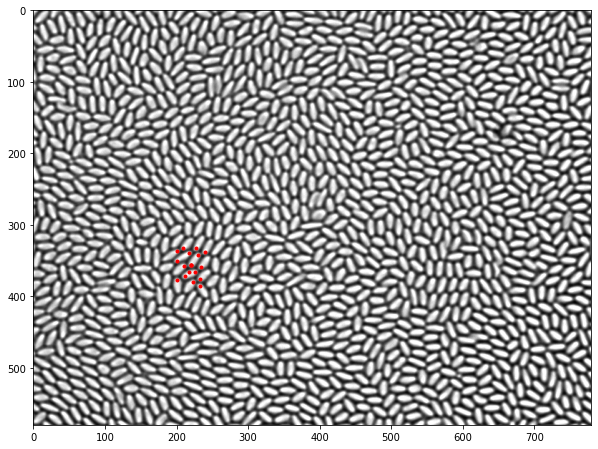

In [ ]:
# plotting some samples of copy2, note first sample of any data in copy2 is pivot and rest are points which are d distance under x and y.
plt.subplots(1,1,figsize=[10,10]);plt.subplot(1,1,1);plt.imshow(data1,cmap="gray")
for i in copy2[789]:
  plt.plot(i[0],i[1],"r.")
#copy2 are points wgich are d distance under in x and y axis.

In [ ]:
main

array([[243, 243, 243, ..., 239, 243, 243],
       [235, 241, 243, ..., 222, 240, 243],
       [229, 224, 218, ..., 195, 216, 234],
       ...,
       [104, 128, 154, ...,  72,  94, 119],
       [ 72,  88, 106, ...,  52,  60,  66],
       [ 55,  65,  74, ...,  48,  42,  43]], dtype=uint8)

In [ ]:
def calc(x,y):
  out=((x[0]-y[0])**(2)+(x[1]-y[1])**2)**(1/2)
  return out
from skimage.measure import profile_line as prof_line
final_data_points=[]          #these will contain data ppoints which are d distance under x and y axis and profile line along it will be greater than threshold.
filter=copy2.copy()
for array in filter:
  pivot=array[0]
  pivot_x=pivot[0]
  pivot_y=pivot[1]
  target=[]
  for particle in array:
    trial=prof_line(main,(pivot_y,pivot_x),(particle[1],particle[0]),order=1,mode="nearest")
    if np.min(trial)<180:
      continue
    else:
      if particle not in target:
        target.append(particle)
  if len(target)>2:
    #print(target)
    min=0
    p1=None
    p2=None
    for i in target:
      for j in target:
        output=calc(i,j)
        #print(output,i,j)
        if output>min and output!=0:
          min=output
          p1=i
          p2=j
    target=[p1,p2]
  if len(target)<2:
    continue
  final_data_points.append(target)

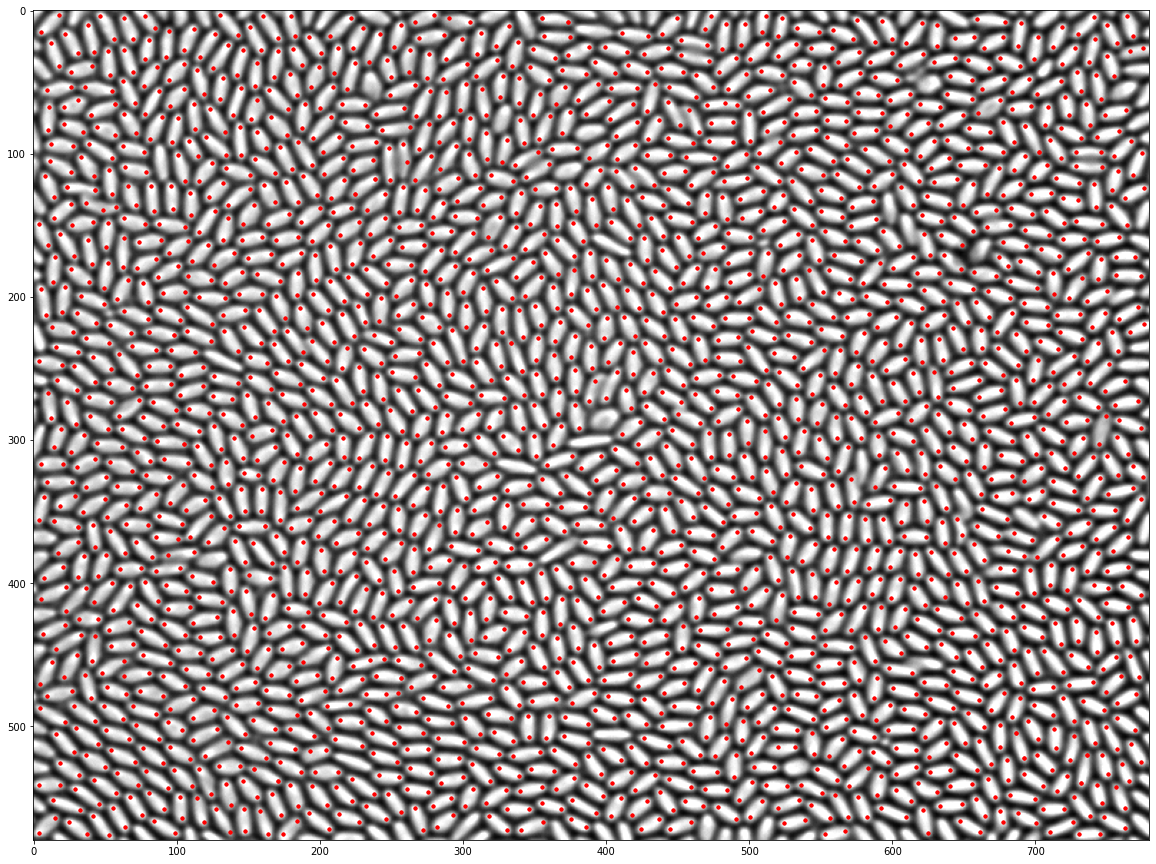

In [ ]:
final_data_points
plt.subplots(1,1,figsize=[20,20]);plt.subplot(1,1,1);plt.imshow(data1,cmap="gray")
one =final_data_points[788]
for j in final_data_points:
  for k in j:
    plt.plot(k[0],k[1],"r.")